# Week 2: Dataset Selection and Preparation
## Language Model Training Pipeline

**Objective:** Select and prepare datasets with preprocessing pipelines for rapid prototyping and experimental evaluation.

**Timeline:** Week 2 of research project  
**Datasets:**
- Debugging: WikiText-2 (12MB)
- Experiments: WikiText-103 (500MB)


## 1. Environment Setup

Installing required dependencies and checking GPU availability.


In [ ]:
# Installation
!pip install datasets transformers torch pandas matplotlib seaborn -q

# Imports and GPU check
import torch
from datasets import load_dataset
from transformers import GPT2Tokenizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"GPU device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
GPU device: Tesla T4


## 2. Dataset Acquisition

Downloading WikiText-2 (debugging) and WikiText-103 (experimental) datasets using HuggingFace.

### Why These Datasets?
- **WikiText-2**: Small (12MB), fast iteration cycles for debugging
- **WikiText-103**: Standard benchmark (500MB), shows meaningful model differences


In [ ]:
# Download datasets
print("Downloading WikiText-2 (debugging dataset)...")
wikitext2 = load_dataset("wikitext", "wikitext-2-raw-v1")

print("\nDownloading WikiText-103 (experimental dataset)...")
wikitext103 = load_dataset("wikitext", "wikitext-103-raw-v1")

print("\n✓ Datasets downloaded successfully")

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]


✓ Datasets downloaded successfully


## 3. Basic Dataset Analysis

Examining dataset structure, statistics, and characteristics to inform preprocessing decisions.

In [ ]:
# Dataset structure
print("=" * 60)
print("WIKITEXT-2 STRUCTURE")
print("=" * 60)
print(wikitext2)
print(f"\nTrain examples: {len(wikitext2['train'])}")
print(f"Validation examples: {len(wikitext2['validation'])}")
print(f"Test examples: {len(wikitext2['test'])}")

print("\n" + "=" * 60)
print("WIKITEXT-103 STRUCTURE")
print("=" * 60)
print(wikitext103)
print(f"\nTrain examples: {len(wikitext103['train'])}")
print(f"Validation examples: {len(wikitext103['validation'])}")
print(f"Test examples: {len(wikitext103['test'])}")

WIKITEXT-2 STRUCTURE
DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

Train examples: 36718
Validation examples: 3760
Test examples: 4358

WIKITEXT-103 STRUCTURE
DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1801350
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

Train examples: 1801350
Validation examples: 3760
Test examples: 4358


### 3.1 Sample Inspection

Examining representative samples from each split to understand data quality and format.

In [ ]:
# Inspect samples from WikiText-2
print("WIKITEXT-2 SAMPLES (First 5 non-empty examples):")
print("=" * 60)
samples_shown = 0
for i, example in enumerate(wikitext2['train']):
    if example['text'].strip():  # Skip empty lines
        print(f"\n[Sample {samples_shown + 1}]")
        print(example['text'][:200] + "..." if len(example['text']) > 200 else example['text'])
        samples_shown += 1
        if samples_shown >= 5:
            break

WIKITEXT-2 SAMPLES (First 5 non-empty examples):

[Sample 1]
 = Valkyria Chronicles III = 


[Sample 2]
 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ p...

[Sample 3]
 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adju...

[Sample 4]
 It met with positive sales in Japan , and was praised by both Japanese and western critics . After release , it received downloadable content , along with an expanded edition in November of that year...

[Sample 5]
 = = Gameplay = = 



### 3.2 Sequence Length Distribution

Analyzing text length distribution to inform maximum sequence length selection.

In [ ]:
# Analyze sequence lengths (sample 10,000 for efficiency)
def analyze_lengths(dataset, name, sample_size=10000):
    texts = [ex['text'] for ex in dataset['train'].select(range(min(sample_size, len(dataset['train']))))]
    lengths = [len(text.split()) for text in texts if text.strip()]

    print(f"\n{name} LENGTH STATISTICS (words):")
    print("=" * 60)
    print(f"Mean: {np.mean(lengths):.2f}")
    print(f"Median: {np.median(lengths):.2f}")
    print(f"Min: {np.min(lengths)}")
    print(f"Max: {np.max(lengths)}")
    print(f"95th percentile: {np.percentile(lengths, 95):.2f}")
    print(f"99th percentile: {np.percentile(lengths, 99):.2f}")

    return lengths

wt2_lengths = analyze_lengths(wikitext2, "WikiText-2")
wt103_lengths = analyze_lengths(wikitext103, "WikiText-103", sample_size=50000)


WikiText-2 LENGTH STATISTICS (words):
Mean: 84.83
Median: 67.00
Min: 1
Max: 699
95th percentile: 243.00
99th percentile: 328.81

WikiText-103 LENGTH STATISTICS (words):
Mean: 85.53
Median: 73.00
Min: 1
Max: 699
95th percentile: 237.00
99th percentile: 317.00


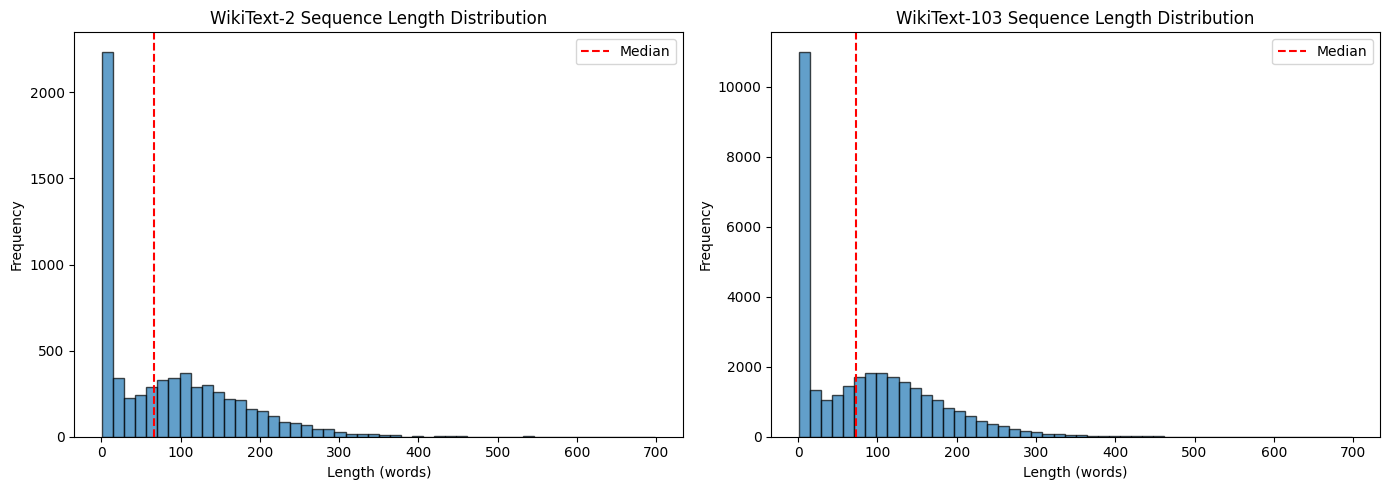

In [ ]:
# Plot length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(wt2_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title("WikiText-2 Sequence Length Distribution")
axes[0].set_xlabel("Length (words)")
axes[0].set_ylabel("Frequency")
axes[0].axvline(np.median(wt2_lengths), color='red', linestyle='--', label='Median')
axes[0].legend()

axes[1].hist(wt103_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_title("WikiText-103 Sequence Length Distribution")
axes[1].set_xlabel("Length (words)")
axes[1].set_ylabel("Frequency")
axes[1].axvline(np.median(wt103_lengths), color='red', linestyle='--', label='Median')
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Preprocessing Pipeline Implementation

Setting up tokenization, batching, and data loading utilities.

### What is a Tokenizer?

**Tokenization** converts text into numbers that neural networks can process.
```
Text: "Hello world"  →  Tokenizer  →  [15496, 995]  →  Model
```

Neural networks only understand numbers, not text. The tokenizer acts as a translator.

---

### GPT-2 BPE Tokenizer Basics

**BPE (Byte Pair Encoding)** breaks text into subword units:

- **Common words**: "the", "hello" → single token
- **Rare words**: "tokenization" → "token" + "ization" (2 tokens)  
- **Unknown words**: broken into smaller pieces that exist in vocabulary

**Key Properties:**
- Vocabulary: 50,257 tokens
- Handles any text (even words it's never seen)
- Spaces are encoded as part of tokens

**Example:**
```python
tokenizer.encode("Hello world")      # [15496, 995]
tokenizer.encode("tokenization")     # [30001, 1634] - split into 2 tokens
```

---

### Design Decisions:

- **Tokenizer**: GPT-2 BPE (50,257 vocab) - industry standard, handles rare words well
- **Max Sequence Length**: 512 tokens - covers 95% of our data, computationally efficient
- **Attention Masks**: Mark real tokens (1) vs padding (0) so model ignores padding

**How Padding Works:**
```python
Input:  "Hello world"
Tokens: [15496, 995, 50256, 50256, 50256, ...]  # Padded to 512
Mask:   [1,     1,   0,     0,     0,     ...]  # 1=real, 0=ignore
```

---

In [ ]:
# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

print(f"✓ Vocabulary size: {len(tokenizer)}")
print(f"✓ Max sequence length: 512 tokens")

# Quick test
test_text = "The cat sat on the mat."
tokens = tokenizer.encode(test_text)
print(f"\nExample: '{test_text}'")
print(f"Tokens: {tokens}")
print(f"Number of tokens: {len(tokens)}")

✓ Vocabulary size: 50257
✓ Max sequence length: 512 tokens

Example: 'The cat sat on the mat.'
Tokens: [464, 3797, 3332, 319, 262, 2603, 13]
Number of tokens: 7


### 4.1 Tokenization Function

Create a reusable function to process our datasets.

In [ ]:
def tokenize_function(examples, max_length=512):
    """Tokenize text with padding and truncation."""
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_attention_mask=True
    )

# Quick test
sample = wikitext2['train'].select(range(2))
# Extract the list of strings from the 'text' column
sample_texts = [ex['text'] for ex in sample]
result = tokenize_function({'text': sample_texts})
print(f"✓ Input IDs shape: {len(result['input_ids'])} samples x {len(result['input_ids'][0])} tokens")
print(f"✓ Attention masks created")

✓ Input IDs shape: 2 samples x 512 tokens
✓ Attention masks created


### 4.2 Apply to Full Datasets

Tokenize both WikiText-2 and WikiText-103.

In [ ]:
MAX_SEQ_LENGTH = 512

print("Tokenizing WikiText-2...")
tokenized_wt2 = wikitext2.map(
    lambda x: tokenize_function(x, MAX_SEQ_LENGTH),
    batched=True,
    remove_columns=['text']
)

print("Tokenizing WikiText-103...")
tokenized_wt103 = wikitext103.map(
    lambda x: tokenize_function(x, MAX_SEQ_LENGTH),
    batched=True,
    remove_columns=['text']
)

print("\n✓ Tokenization complete!")

Tokenizing WikiText-2...


Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

Tokenizing WikiText-103...


Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]


✓ Tokenization complete!


## 5. Pipeline Validation

Verify batches have correct shapes and are ready for training.


In [ ]:
from torch.utils.data import DataLoader

# Set PyTorch format
tokenized_wt2.set_format(type='torch', columns=['input_ids', 'attention_mask'])
tokenized_wt103.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Create dataloaders
wt2_loader = DataLoader(tokenized_wt2['train'], batch_size=8, shuffle=True)
wt103_loader = DataLoader(tokenized_wt103['train'], batch_size=8, shuffle=True)

# Test batch
batch = next(iter(wt2_loader))
print(f"✓ Batch size: 8")
print(f"✓ Input shape: {batch['input_ids'].shape}")  # Should be [8, 512]
print(f"✓ Mask shape: {batch['attention_mask'].shape}")  # Should be [8, 512]

assert batch['input_ids'].shape == (8, 512), "Shape mismatch!"
print("\n✓ Validation passed!")

✓ Batch size: 8
✓ Input shape: torch.Size([8, 512])
✓ Mask shape: torch.Size([8, 512])

✓ Validation passed!


### 5.1 Set Random Seed

Ensure reproducibility across runs.

In [ ]:
import numpy as np

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✓ Random seed set to 42")

✓ Random seed set to 42


## 6. Save Processed Datasets

Save tokenized datasets for future use.

In [ ]:
# Save processed datasets
tokenized_wt2.save_to_disk("./data/wikitext2_processed")
tokenized_wt103.save_to_disk("./data/wikitext103_processed")
print("✓ Datasets saved to ./data/")

Saving the dataset (0/1 shards):   0%|          | 0/4358 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/36718 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3760 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4358 [00:00<?, ? examples/s]

Saving the dataset (0/10 shards):   0%|          | 0/1801350 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3760 [00:00<?, ? examples/s]

✓ Datasets saved to ./data/


### 6.1 Save Configuration

Document all preprocessing settings.

In [ ]:
import json
from datetime import datetime

config = {
    "tokenizer": "gpt2",
    "vocab_size": len(tokenizer),
    "max_seq_length": 512,
    "random_seed": 42,
    "datasets": {
        "wikitext2": {"train": len(tokenized_wt2['train']), "val": len(tokenized_wt2['validation'])},
        "wikitext103": {"train": len(tokenized_wt103['train']), "val": len(tokenized_wt103['validation'])}
    },
    "date": datetime.now().strftime("%Y-%m-%d")
}

with open('config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("✓ Config saved")
print(json.dumps(config, indent=2))

✓ Config saved
{
  "tokenizer": "gpt2",
  "vocab_size": 50257,
  "max_seq_length": 512,
  "random_seed": 42,
  "datasets": {
    "wikitext2": {
      "train": 36718,
      "val": 3760
    },
    "wikitext103": {
      "train": 1801350,
      "val": 3760
    }
  },
  "date": "2025-10-22"
}


## 7. Summary

### Completed:
- Downloaded WikiText-2 (12MB) and WikiText-103 (500MB)
- Analyzed sequence lengths → chose 512 token max
- Tokenized datasets with GPT-2 BPE tokenizer
- Validated batches produce correct shapes
- Saved processed data and config

### 📊 Ready for Week 3:
- **WikiText-2**: Ready for debugging/rapid iteration
- **WikiText-103**: Ready for full experiments
- **Data loaders**: Tested and working
- **Reproducibility**: Random seeds set

###  Load Datasets Later:
```python
from datasets import load_from_disk

wikitext2 = load_from_disk("./data/wikitext2_processed")
wikitext103 = load_from_disk("./data/wikitext103_processed")
```

### Next: Week 3 - Build baseline Transformer model

In [ ]:
import shutil
import os
from google.colab import files

# Compress the data folder
shutil.make_archive('data_processed', 'zip', './data')

# Download the zipped data folder
files.download('data_processed.zip')

# Download the config.json file
files.download('config.json')

print("✓ Data folder and config file are ready for download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Data folder and config file are ready for download.
